In [24]:
from position_utils import *
import position_utils
import os
import numpy as np
import importlib
import pandas as pd
import re
importlib.reload(position_utils)

<module 'position_utils' from '/gpfs/helios/home/khajuria/Constellations_AI/Plos CB/FashionMnist/Human/position_utils.py'>

In [15]:
ground_truth_dir = '../Dataset/Selected_dotted/'
human_sol_dir = 'Last_drawings/'
dl_solutions_dir = '../Search/Sol_11/'
constellations_dir = '../Dataset/Selected_images/'
data_dir = 'Raw_data_edited/'

In [16]:
labels = np.load('../Dataset/fashion_constellation_test_sel_11.npz')['labels']

In [17]:
labels = labels.astype(int)

In [22]:
data_files =os.listdir(data_dir)

In [18]:
def find_common_dots(dots1,dots2):
    common_dots = []
    for dot1 in dots1:
        for dot2 in dots2:
            (x1,y1),radius = cv2.minEnclosingCircle(dot1)
            (x2,y2),radius = cv2.minEnclosingCircle(dot2)
            if(x1==x2 and y1==y2):
                common_dots.append(dot1)
    return common_dots
                

In [19]:
acc = []
coverage = []
IOUs= []
users = os.listdir(human_sol_dir)
flag = False
for user in users:
    user_dir = human_sol_dir + user+'/'
    images = os.listdir(user_dir)
    for stim in images:
        if(stim == '.ipynb_checkpoints'):
            continue
        stimuli = stim.split('_')[1].split('.')[0]
        constellation_path = 'test_'
        constellation_path = constellations_dir+constellation_path+stimuli+'_'+str(int(labels[int(stimuli)]))+'.jpg'
        human_drawing = cv2.imread(user_dir+stim,cv2.IMREAD_GRAYSCALE)
        constellation = cv2.imread(constellation_path)
        search_path = dl_solutions_dir + 'image_'+stimuli+'.jpg'
        search = cv2.imread(search_path,cv2.IMREAD_GRAYSCALE)
        dots = stimuli_dots(constellation)
        human_points = points_on_image(human_drawing,dots,3)
        search_points = points_on_image(search,dots,3)
        common_points = find_common_dots(human_points,search_points)
        intersection = len(common_points)
        union = len(search_points)+len(human_points)-len(common_points)
        iou = intersection/union
        if(len(human_points)==0):
            continue
        IOUs.append(iou)
        
#         gt_contour = cv2.imread(ground_truth_dir+name)
#         print(ground_truth_dir+name)
#         const = cv2.imread(stimuli_dir + stim)
#         dots = stimuli_dots(const)
#         gt_dots = points_on_image(gt_contour,dots,0)
#         bottom_up = cv2.imread(bottom_up_dir+stim)
#         bottom_up_dots = points_on_image(bottom_up,gt_dots,0)
#         bottom_up_total = points_on_image(bottom_up,dots,0)
#         coverage.append(len(bottom_up_dots)/len(gt_dots))
#         if(len(bottom_up_total)==0):
#             acc.append(0)
#             continue
#         acc.append(len(bottom_up_dots)/len(bottom_up_total))
# coverage = np.array(coverage)
# acc = np.array(acc)
# print('recall',np.mean(coverage),np.var(coverage))
# print('specificity',np.mean(acc),np.var(acc))        

In [75]:
count_dots = []
count_drawn = []
certain = []
pleasant = []
for user in users:
    user_dir = human_sol_dir + user+'/'
    images = os.listdir(user_dir)
    if(user == '.ipynb_checkpoints'):
        continue
    matches = list(filter(lambda s: re.match(r'^'+user, s), data_files))
    data = pd.read_csv(data_dir+matches[0])
    for stim in images:
        if(stim == '.ipynb_checkpoints'):
            continue
        stimuli = stim.split('_')[1].split('.')[0]
        row = data[data['stimulus'].str.contains('test_'+stimuli)]
        cer = row['RSP_ahhaa.response'].values[0]
        diff = row['RSP_pleasant.response'].values[0]
        if(np.isnan(cer) or np.isnan(diff)):
            continue
        certain.append(diff)
        pleasant.append(cer)
        
        constellation_path = 'test_'
        constellation_path = constellations_dir+constellation_path+stimuli+'_'+str(int(labels[int(stimuli)]))+'.jpg'
        human_drawing = cv2.imread(user_dir+stim,cv2.IMREAD_GRAYSCALE)
        constellation = cv2.imread(constellation_path)
        dots = stimuli_dots(constellation)
        human_points = points_on_image(human_drawing,dots,3)
        count_dots.append(len(dots))
        count_drawn.append(len(human_points))
        
        

In [76]:
adj = np.array(count_drawn)/np.array(count_dots)

In [77]:
import scipy
scipy.stats.pearsonr(count_drawn,certain)

PearsonRResult(statistic=-0.08942310697164714, pvalue=0.07853101635283861)

In [78]:
scipy.stats.pearsonr(count_drawn,pleasant)

PearsonRResult(statistic=0.07551672849060395, pvalue=0.1375892349050417)

In [79]:
scipy.stats.pearsonr(adj,pleasant)

PearsonRResult(statistic=0.10383827073831994, pvalue=0.04092325785016425)

In [80]:
scipy.stats.pearsonr(adj,certain)

PearsonRResult(statistic=-0.14720229594938827, pvalue=0.003660343839654473)

In [83]:
scipy.stats.spearmanr(adj,pleasant)
scipy.stats.spearmanr(adj,certain)

SignificanceResult(statistic=-0.18206019817465333, pvalue=0.00031242847583020847)

In [28]:
data[data['stimulus'].str.contains('test_29')]

,stimulus,stim,Correct,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,mouse_track_2.x,mouse_track_2.y,mouse_track_2.leftButton,...,RSP_pleasant.rt,RSP_pleasant.history,Pseudonym*,Age,Gender,date,expName,psychopyVersion,frameRate,Unnamed: 48
0,test_29_4.jpg,stimuli/test_29_4.jpg,Coat,0,0,0,29,NaN,NaN,NaN,...,138.791237,"[(5.0, 138.79123690002598)]",tk,NaN,NaN,2024_Oct_01_1513,Constellations24,2021.1.4,59.968972,NaN


In [30]:
data.columns

Index(['stimulus', 'stim', 'Correct', 'trials.thisRepN', 'trials.thisTrialN',
       'trials.thisN', 'trials.thisIndex', 'mouse_track_2.x',
       'mouse_track_2.y', 'mouse_track_2.leftButton',
       'mouse_track_2.midButton', 'mouse_track_2.rightButton',
       'mouse_track_2.time', 'H1_textbox_2.text', 'button_hint_2.started',
       'button_hint_2.stopped', 'button_yes_2.started', 'button_yes_2.stopped',
       'mouse_track.x', 'mouse_track.y', 'mouse_track.leftButton',
       'mouse_track.midButton', 'mouse_track.rightButton', 'mouse_track.time',
       'H1_textbox.text', 'mouse1.x_draw', 'mouse1.y_draw', 'Clear pressed',
       'button_hint.started', 'button_hint.stopped', 'button_yes.started',
       'button_yes.stopped', 'RSP_ahhaa.response', 'RSP_ahhaa.rt',
       'RSP_ahhaa.history', 'RSP_sudden.response', 'RSP_sudden.rt',
       'RSP_sudden.history', 'RSP_pleasant.response', 'RSP_pleasant.rt',
       'RSP_pleasant.history', 'Pseudonym*', 'Age', 'Gender', 'date',
       'expN

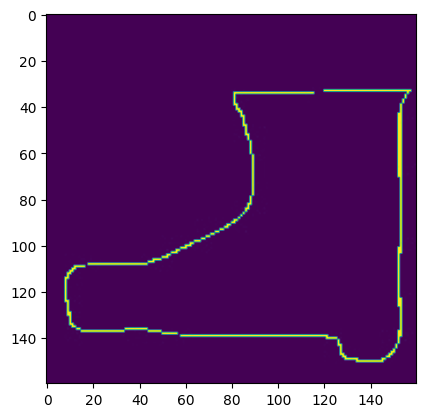

In [34]:
from matplotlib import pyplot as plt
plt.imshow(human_drawing)

In [87]:
def drawing_figure(image,base=None):
    ''' find the drawn contour on the image'''
    image[image<100]=0
    image[image>100]=255
    cnts = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[-2]
    if(base is None):
        draw_img = np.zeros((160,160)).astype(np.uint8)
    else:
        draw_img = base.astype(np.uint8)
    for s in cnts:
        for pt in s:
            draw_img[pt[0][1],pt[0][0]] =255
    return draw_img

In [90]:
search_constellations = drawing_figure(search,constellation)
human_constellations = drawing_figure(human_drawing,constellation)

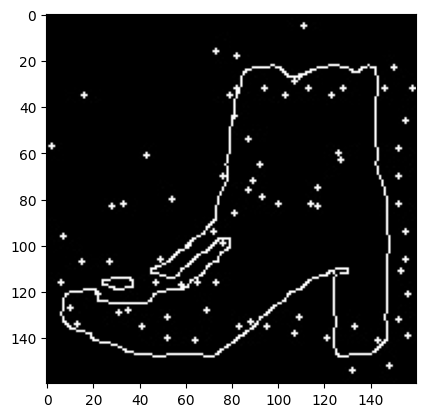

In [91]:
plt.imshow(search_constellations)

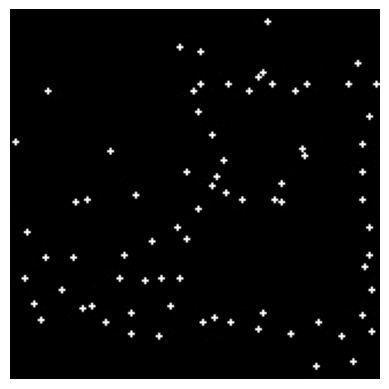

In [38]:
plt.axis(False)
plt.imshow(constellation)

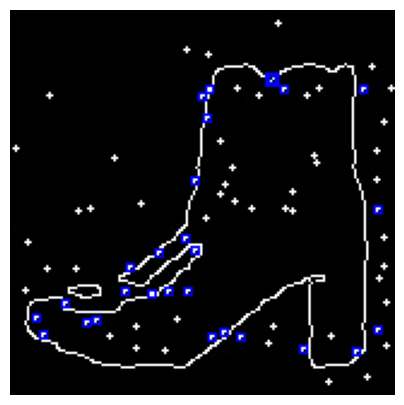

In [92]:
im = search_constellations.copy()
#im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
for c in search_points:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(5,5))
plt.axis(False)
plt.imshow(im)


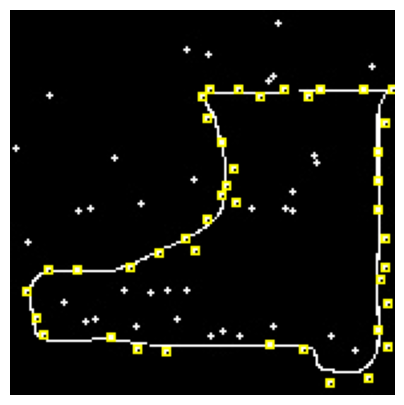

In [94]:
im = human_constellations.copy()
#im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
for c in human_points:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    cv2.rectangle(im,(x,y),(x+w,y+h),(255,255,0),1)
plt.figure(figsize=(5,5))
plt.axis(False)
plt.imshow(im)

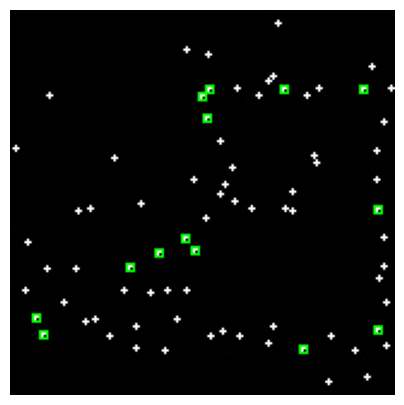

In [14]:
im = constellation.copy()
#im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
for c in common_points:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
plt.figure(figsize=(5,5))
plt.axis(False)
plt.imshow(im)

In [48]:
IOUs[-1]

0.25

In [49]:
len(search_points)

28

In [50]:
len(human_points)

42

In [51]:
search_points

[array([[[143, 140]],
 
        [[142, 141]],
 
        [[143, 142]],
 
        [[144, 141]]], dtype=int32),
 array([[[121, 139]],
 
        [[120, 140]],
 
        [[121, 141]],
 
        [[122, 140]]], dtype=int32),
 array([[[ 95, 134]],
 
        [[ 94, 135]],
 
        [[ 95, 136]],
 
        [[ 96, 135]]], dtype=int32),
 array([[[ 83, 134]],
 
        [[ 82, 135]],
 
        [[ 83, 136]],
 
        [[ 84, 135]]], dtype=int32),
 array([[[ 13, 133]],
 
        [[ 12, 134]],
 
        [[ 13, 135]],
 
        [[ 14, 134]]], dtype=int32),
 array([[[ 88, 132]],
 
        [[ 87, 133]],
 
        [[ 88, 134]],
 
        [[ 89, 133]]], dtype=int32),
 array([[[152, 131]],
 
        [[151, 132]],
 
        [[152, 133]],
 
        [[153, 132]]], dtype=int32),
 array([[[ 31, 128]],
 
        [[ 30, 129]],
 
        [[ 31, 130]],
 
        [[ 32, 129]]], dtype=int32),
 array([[[ 35, 127]],
 
        [[ 34, 128]],
 
        [[ 35, 129]],
 
        [[ 36, 128]]], dtype=int32),
 array([[[ 10, 126]

In [52]:
search_path

'../Search/Sol_11/image_7.jpg'

In [53]:
np.mean(IOUs)

0.48976354190154453

In [54]:
common= find_common_dots(dots,dots)

In [95]:
len(dots)+len(dots)-len(common)

84

In [96]:
len(common)/84

1.0